In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("clean_data.csv")
df = df[~df['food_wheel_group'].isin(['Other'])].copy()

In [3]:
nutrient_cols = [
    'FAT (g)', 'PROT (g)', 'Carbohydrates (kcal)',
    'VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)', 'VITB12 (µg)', 'VITD (µg)',
    'VITE (mg)', 'VITC (mg)', 'VITA (µg)',
    'Calcium (mg)', 'Iron (mg)', 'Magnesium (mg)', 'Phosphorus (mg)',
    'Potassium (mg)', 'Sodium (mg)', 'Zinc (mg)'
]

df_clean = df.dropna(subset=nutrient_cols).copy()


In [4]:
df_clean['Protein_per_kcal'] = df_clean['PROT (g)'] / (df_clean['Carbohydrates (kcal)'] + df_clean['FAT (g)'] + 1)
df_clean['Fat_to_Protein'] = df_clean['FAT (g)'] / (df_clean['PROT (g)'] + 1)
df_clean['Carb_to_Protein'] = df_clean['Carbohydrates (kcal)'] / (df_clean['PROT (g)'] + 1)
df_clean['Sodium_to_Potassium'] = df_clean['Sodium (mg)'] / (df_clean['Potassium (mg)'] + 1)

micro_cols = ['VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)', 'VITB12 (µg)', 'VITD (µg)', 
              'VITE (mg)', 'VITC (mg)', 'VITA (µg)', 'Calcium (mg)', 'Iron (mg)', 
              'Magnesium (mg)', 'Phosphorus (mg)', 'Potassium (mg)', 'Zinc (mg)']
df_clean['Micronutrient_Density'] = df_clean[micro_cols].sum(axis=1) / (df_clean['Carbohydrates (kcal)'] + 1)

features = nutrient_cols + [
    'Protein_per_kcal', 'Fat_to_Protein', 'Carb_to_Protein',
    'Sodium_to_Potassium', 'Micronutrient_Density'
]

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

In [6]:
sil_scores = {}
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

optimal_k = max(sil_scores, key=sil_scores.get)
print(f"Optimal number of clusters (diet types): {optimal_k} (Silhouette = {sil_scores[optimal_k]:.3f})")

Optimal number of clusters (diet types): 4 (Silhouette = 0.318)


In [7]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['diet_cluster'] = kmeans.fit_predict(X_scaled)

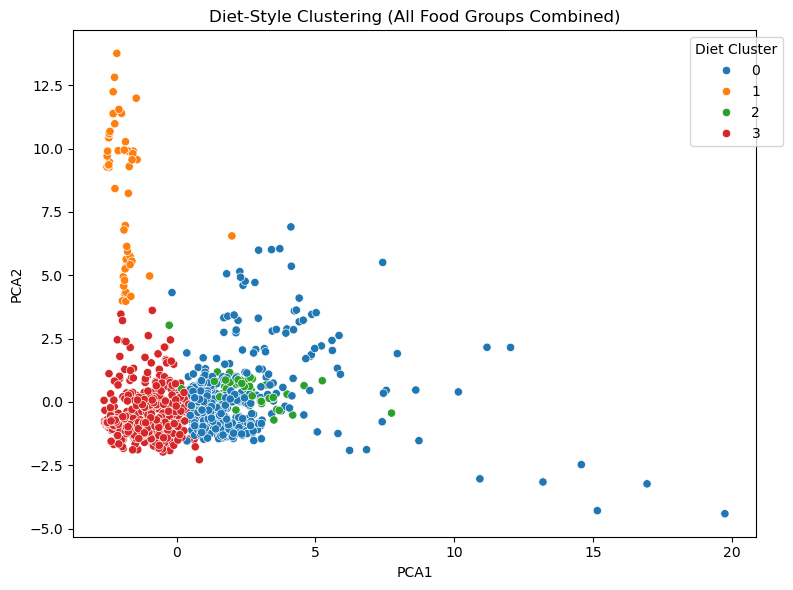

In [8]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_clean['PCA1'] = pca_result[:, 0]
df_clean['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='diet_cluster', palette='tab10')
plt.title("Diet-Style Clustering (All Food Groups Combined)")
plt.legend(title="Diet Cluster", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [9]:
print("\n=== Diet Cluster Nutrient Profiles ===")
cluster_profiles = df_clean.groupby('diet_cluster')[features].mean().round(2)
print(cluster_profiles)

print("\n=== Food Group Composition per Diet Cluster ===")
composition = df_clean.groupby(['diet_cluster', 'food_wheel_group']).size()
display(composition)


=== Diet Cluster Nutrient Profiles ===
              FAT (g)  PROT (g)  Carbohydrates (kcal)  VITB1 (mg)  RIBF (mg)  \
diet_cluster                                                                   
0               14.13     18.65                269.34        0.31       0.29   
1               79.04      0.19                713.49        0.04       0.03   
2               21.60     22.18                311.15        0.05       0.33   
3                3.81      3.69                122.10        0.06       0.08   

              VITB6 (mg)  VITB12 (µg)  VITD (µg)  VITE (mg)  VITC (mg)  ...  \
diet_cluster                                                            ...   
0                   0.36         3.10       1.27       2.51       2.11  ...   
1                   0.03         0.08       3.74      18.70       0.00  ...   
2                   0.08         1.73       0.24       0.88       0.75  ...   
3                   0.08         0.12       0.10       0.81       9.47  ...   

    

diet_cluster  food_wheel_group                         
0             Bread, grain/cereal products and potatoes     87
              Dairy, nuts, fish, legumes, meat and eggs    313
              Drinks                                         2
              Spreading and cooking fats                    18
              Vegetables and fruit                           6
1             Spreading and cooking fats                    51
2             Bread, grain/cereal products and potatoes      2
              Dairy, nuts, fish, legumes, meat and eggs     57
              Drinks                                         1
              Vegetables and fruit                           1
3             Bread, grain/cereal products and potatoes    177
              Dairy, nuts, fish, legumes, meat and eggs    212
              Drinks                                        92
              Spreading and cooking fats                    21
              Vegetables and fruit                         295

In [10]:
cluster_labels = {
    0: "Balanced Omnivore",
    1: "Strict Ketogenic",
    2: "Protein Focused",
    3: "Whole Food Plant Based"
}
df_clean['diet_label'] = df_clean['diet_cluster'].map(cluster_labels)

In [11]:
print(df_clean.groupby('diet_label')[features].mean().round(2))

                        FAT (g)  PROT (g)  Carbohydrates (kcal)  VITB1 (mg)  \
diet_label                                                                    
Balanced Omnivore         14.13     18.65                269.34        0.31   
Protein Focused           21.60     22.18                311.15        0.05   
Strict Ketogenic          79.04      0.19                713.49        0.04   
Whole Food Plant Based     3.81      3.69                122.10        0.06   

                        RIBF (mg)  VITB6 (mg)  VITB12 (µg)  VITD (µg)  \
diet_label                                                              
Balanced Omnivore            0.29        0.36         3.10       1.27   
Protein Focused              0.33        0.08         1.73       0.24   
Strict Ketogenic             0.03        0.03         0.08       3.74   
Whole Food Plant Based       0.08        0.08         0.12       0.10   

                        VITE (mg)  VITC (mg)  ...  Magnesium (mg)  \
diet_label       

In [12]:
cluster_summary = df_clean.groupby('diet_label')['food_wheel_group'].value_counts().unstack().fillna(0)
print(cluster_summary)

food_wheel_group        Bread, grain/cereal products and potatoes  \
diet_label                                                          
Balanced Omnivore                                            87.0   
Protein Focused                                               2.0   
Strict Ketogenic                                              0.0   
Whole Food Plant Based                                      177.0   

food_wheel_group        Dairy, nuts, fish, legumes, meat and eggs  Drinks  \
diet_label                                                                  
Balanced Omnivore                                           313.0     2.0   
Protein Focused                                              57.0     1.0   
Strict Ketogenic                                              0.0     0.0   
Whole Food Plant Based                                      212.0    92.0   

food_wheel_group        Spreading and cooking fats  Vegetables and fruit  
diet_label                                     

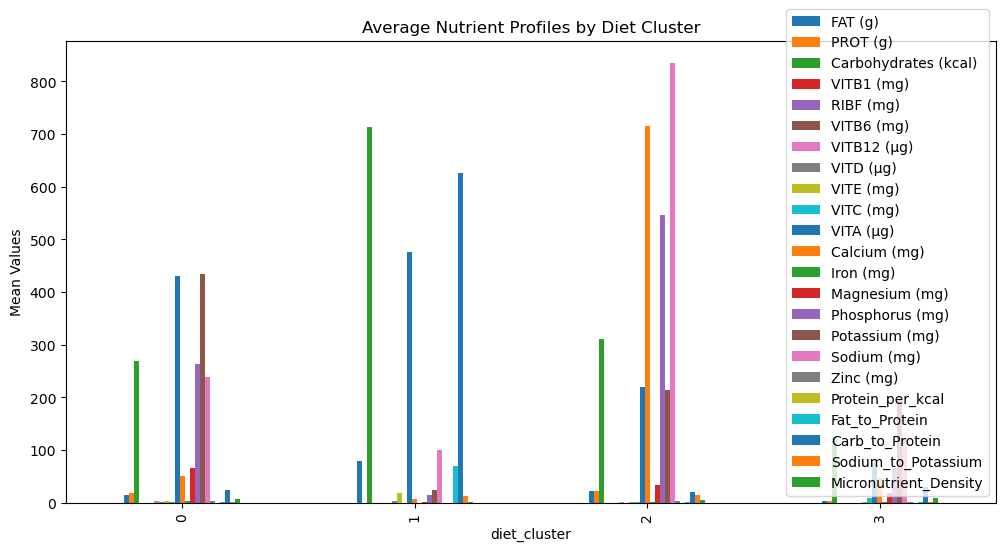

In [13]:
cluster_profiles.plot(kind='bar', figsize=(12, 6))
plt.title("Average Nutrient Profiles by Diet Cluster")
plt.ylabel("Mean Values")
plt.show()

In [14]:
df_clean

,NEVO-code,Food group,Engelse naam/Food name,Hoeveelheid/Quantity,FAT (g),PROT (g),Carbohydrates (kcal),VITB1 (mg),RIBF (mg),VITB6 (mg),...,food_wheel_group,Protein_per_kcal,Fat_to_Protein,Carb_to_Protein,Sodium_to_Potassium,Micronutrient_Density,diet_cluster,PCA1,PCA2,diet_label
0,1,Potatoes and tubers,Potatoes raw,per 100g,0.0,2.0,88.0,0.12,0.04,0.300,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.229551,3,-1.074760,-0.855036,Whole Food Plant Based
1,2,Potatoes and tubers,Potatoes new raw,per 100g,0.0,2.0,88.0,0.12,0.04,0.300,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.250112,3,-1.188388,-0.926915,Whole Food Plant Based
2,3,Potatoes and tubers,Potatoes old raw,per 100g,0.0,2.0,88.0,0.12,0.04,0.220,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.070562,3,-1.133319,-0.819915,Whole Food Plant Based
3,4,Cereals and cereal products,Pasta white raw,per 100g,1.5,12.3,356.0,0.10,0.06,0.080,...,"Bread, grain/cereal products and potatoes",0.034310,0.112782,26.766917,0.019802,0.831204,3,-0.255705,-0.136718,Whole Food Plant Based
4,5,Cereals and cereal products,Rice white raw,per 100g,1.0,7.0,352.0,0.04,0.03,0.120,...,"Bread, grain/cereal products and potatoes",0.019774,0.125000,44.000000,0.019802,0.638782,3,-1.077163,-0.063719,Whole Food Plant Based
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,5571,Meat substitutes and dairy substitutes,Drink soya chocolate w sugar fortified w calci...,per 100g,1.7,3.0,60.0,0.02,0.20,0.047,...,"Dairy, nuts, fish, legumes, meat and eggs",0.047847,0.425000,15.000000,0.309392,6.657164,3,-1.118708,-0.822045,Whole Food Plant Based
2003,5572,Meat substitutes and dairy substitutes,Bacon vegetarian unprepared,per 100g,10.5,15.0,185.0,0.04,0.17,0.041,...,"Dairy, nuts, fish, legumes, meat and eggs",0.076336,0.656250,11.562500,2.510689,3.865973,0,0.913422,-0.321661,Balanced Omnivore
2004,5573,Meat substitutes and dairy substitutes,Tempeh unprepared,per 100g,4.7,17.6,128.0,0.03,0.18,0.091,...,"Dairy, nuts, fish, legumes, meat and eggs",0.131638,0.252688,6.881720,0.125402,5.058302,0,0.651323,-0.942664,Balanced Omnivore
2005,5574,Cereals and cereal products,Bakery mix for doughnuts Dutch style,per 100g,1.0,11.0,367.0,0.09,0.09,0.134,...,"Bread, grain/cereal products and potatoes",0.029810,0.083333,30.583333,4.047619,0.875826,3,-0.407524,0.035401,Whole Food Plant Based
